In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
import pandas as pd
import sys

# If you want to include other modules, you can add them here
# Please note the recommendations on using modules in the Programming General Guidelines

#recommended resource for examples: https://scikit-learn.org/stable/modules/feature_extraction.html

from collections import defaultdict, Counter, OrderedDict
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import csv
from scipy.sparse import hstack
from tqdm import tqdm
np.set_printoptions(suppress=True)

In [9]:
data_folder = "../../data/conll2003/"

train_file = data_folder + "conll2003.train.conll"
test_file = data_folder + "conll2003.test.conll"
dev_file = data_folder + "conll2003.dev.conll"

In [10]:
# Sames as in assignment 1, use a sample function to get
# sample files and verify the newly-designed functions
def sample_conll(input_file, output_file, line_count):
    """
    The function to sample a small part of the complete .conll file
    used to test the codes for metrics report.

    :params input_file: the complete .conll file to sample from
    :params output_file: the output sample .conll file
    :params line_count: the customized sample size

    """
    with open(input_file, "r") as infile, open(output_file, "w") as outfile:
        for i, line in enumerate(infile):
            if i >= line_count:
                break
            outfile.write(line)


sample_conll(train_file, "sample_gold.conll", 47)

In [11]:
# The function to retrieve if a token itself contains uppercase
# and store as a column in conll
def extract_uppercase(input_file, output_file):
    outfile = open(output_file, 'w')
    infile = open(input_file,'r')
    for line in infile:
        components = line.rstrip('\n').split()
        if len(components) > 0:
            token = components[0]
            contain_uppercase = any(char.isupper() for char in token)
            if contain_uppercase:
                outfile.write(line.rstrip('\n') + '\t' + '1' + '\n')
            else:
                outfile.write(line.rstrip('\n') + '\t' + '0' + '\n')

    outfile.close()

In [12]:
# The function to retrieve if the previous token contains uppercase
# and store as a column in conll
def extract_previous_case(input_file, output_file):
    token_uppercase = []
    with open(input_file, 'r') as infile:
        lines = infile.readlines()
        for line in lines:
            components = line.rstrip('\n').split()
            if len(components) > 0:              
                uppercase =  components[4]
                token_uppercase.append(uppercase)

    with open(output_file, 'w') as outfile:
        for i, line in enumerate(lines):
            if i == 0:
                outfile.write(line.rstrip('\n') + '\t' + '0' + '\n')
            elif token_uppercase[i-1] == '1':
                outfile.write(line.rstrip('\n') + '\t' + '1' + '\n')
            elif token_uppercase[i-1] == '0':
                outfile.write(line.rstrip('\n') + '\t' + '0' + '\n')
        
    outfile.close()

In [13]:
# The function to retrieve if the next token contains uppercase
# and store as a column in conll
def extract_next_case(input_file, output_file):
    token_uppercase = []
    with open(input_file, 'r') as infile:
        lines = infile.readlines()
        for line in lines:
            components = line.rstrip('\n').split()
            if len(components) > 0:              
                uppercase =  components[4]
                token_uppercase.append(uppercase)

    with open(output_file, 'w') as outfile:
        for i, line in enumerate(lines):
            if i == len(lines) - 1:
                outfile.write(line.rstrip('\n') + '\t' + '0' + '\n')
            elif token_uppercase[i+1] == '1':
                outfile.write(line.rstrip('\n') + '\t' + '1' + '\n')
            elif token_uppercase[i+1] == '0':
                outfile.write(line.rstrip('\n') + '\t' + '0' + '\n')
    
        
    outfile.close()

In [14]:
def extract_previous_token(input_file, output_file):
    token_list = []
    with open(input_file, 'r') as infile:
        lines = infile.readlines()
        for line in lines:
            components = line.rstrip('\n').split()
            if len(components) > 0:              
                token =  components[0]
                token_list.append(token)

    with open(output_file, 'w') as outfile:
        for i, line in enumerate(lines):
            if i == 0:
                outfile.write(line.rstrip('\n') + '\t' + '[first]' + '\n')
            else:
                outfile.write(line.rstrip('\n') + '\t' + token_list[i-1] + '\n')
        
    outfile.close()

In [15]:
def extract_next_token(input_file, output_file):
    token_list = []
    with open(input_file, 'r') as infile:
        lines = infile.readlines()
        for line in lines:
            components = line.rstrip('\n').split()
            if len(components) > 0:              
                token =  components[0]
                token_list.append(token)

    with open(output_file, 'w') as outfile:
        for i, line in enumerate(lines):
            if i == len(lines) - 1:
                outfile.write(line.rstrip('\n') + '\t' + '[last]' + '\n')
            else:
                outfile.write(line.rstrip('\n') + '\t' + token_list[i+1] + '\n')
        
    outfile.close()

In [16]:
# The function to retrieve the prefix and suffix with a span of 6, imiataing the setting
# of the feature discussion paper and store as a column in conll
def extract_affix(input_file, output_file, prefix_length = 6, suffix_length = 6):
    outfile = open(output_file, 'w')
    infile = open(input_file, 'r')
    for line in infile:
        components = line.rstrip('\n').split()
        if len(components) > 0:
            token = components[0]
            prefix = token[:prefix_length] if len(token) >= prefix_length else token
            suffix = token[-suffix_length:] if len(token) >= suffix_length else token
            outfile.write(line.rstrip('\n') + '\t' + prefix + '\t' + suffix + '\n')

    outfile.close()

In [17]:
# Sort steps above into a pipeline for convenience
def feature_pipeline(input_file, output_file):
    extract_uppercase(input_file, f'./{input_file}_1.conll')
    extract_previous_case(f'./{input_file}_1.conll', f'./{input_file}_2.conll')
    extract_next_case(f'./{input_file}_2.conll', f'./{input_file}_3.conll')
    extract_previous_token(f'./{input_file}_3.conll', f'./{input_file}_4.conll')
    extract_next_token(f'./{input_file}_4.conll', f'./{input_file}_5.conll')
    extract_affix(f'./{input_file}_5.conll', output_file)

In [18]:
feature_pipeline('./sample_gold.conll', './sample_preprocessed.conll')

In [19]:
feature_pipeline(train_file, './train_features.conll')
feature_pipeline(dev_file, './dev_features.conll')

In [20]:
# Define a new extraction function to sort all current one-hot features into
# a dictionary and also get the gold labels of the specified data
def extract_features_and_labels_onehot(trainingfile):
    """
    The specific function extracts both word tokens and their gold NE annotations
    from the .conll file of the training data. The extraction of word tokens is 
    identical to the function 'extract_features'; the extraction of gold NE annotations
    is achieved by retrieving the last column of every line and storing them in the 
    'target' list. The function eventually returns both the 'data' list and the 'target'
    list.

    :params trainingfile: the .conll file of the training data.
    """
    data = []
    targets = []
    with open(trainingfile, 'r', encoding='utf8') as infile:
        for line in infile:
            components = line.rstrip('\n').split()
            if len(components) > 0:
                token = components[0]
                pos_tag = components[1]
                syntactic_tag = components[2]
                uppercase = components[4]
                prev_uppercase = components[5]
                next_uppercase = components[6]
                prev_token = components[7]
                next_token = components[8]
                prefix = components[9]
                suffix = components[10]
                feature_dict = {'token':token, 'pos_tag':pos_tag, 'syntactic_tag':syntactic_tag, 'uppercase': uppercase,
                               'prev_uppercase': prev_uppercase, 'next_uppercase':next_uppercase, 'prev_token': prev_token, 
                                'next_token': next_token, 'prefix': prefix, 'suffix': suffix}
                data.append(feature_dict)
                # gold is the 3rd column
                targets.append(components[3])
    return data, targets

In [21]:
new_training_file = './train_features.conll'
new_dev_file  = './dev_features.conll'
pred_file = './dev_pred.conll'
pred_file_svm = './dev_pred_svm.conll'

In [22]:
data_t, targets_t = extract_features_and_labels_onehot(new_training_file)
data_d, targets_d = extract_features_and_labels_onehot(new_dev_file)

In [23]:
print(data_d[0])

{'token': 'CRICKET', 'pos_tag': 'NNP', 'syntactic_tag': 'B-NP', 'uppercase': '1', 'prev_uppercase': '0', 'next_uppercase': '0', 'prev_token': '[first]', 'next_token': '-', 'prefix': 'CRICKE', 'suffix': 'RICKET'}


In [24]:
# Adjust the function to include Naive Bayes and SVM
def create_classifier(train_features, train_targets, modelname):
    if modelname ==  'logreg':
        # TIP: you may need to solve this: https://stackoverflow.com/questions/61814494/what-is-this-warning-convergencewarning-lbfgs-failed-to-converge-status-1
        model = LogisticRegression()
    elif modelname == 'NB':
        model = MultinomialNB()
    elif modelname == 'SVM':
        model = LinearSVC()
        
    vec = DictVectorizer()
    features_vectorized = vec.fit_transform(train_features)
    model.fit(features_vectorized, train_targets)
    
    return model, vec
    
    
def classify_data(model, vec, inputdata, outputfile):
  
    features, _ = extract_features_and_labels_onehot(inputdata)
    features = vec.transform(features)
    predictions = model.predict(features)
    outfile = open(outputfile, 'w')
    counter = 0
    for line in open(inputdata, 'r'):
        if len(line.rstrip('\n').split()) > 0:
            outfile.write(line.rstrip('\n') + '\t' + predictions[counter] + '\n')
            counter += 1
    outfile.close()

In [25]:
model_NB, vec_NB = create_classifier(data_t, targets_t, 'NB')

In [26]:
classify_data(model_NB, vec_NB, new_dev_file, pred_file)

In [27]:
model_SVM, vec_SVM = create_classifier(data_t, targets_t, 'SVM')

F:\anaconda\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


In [28]:
classify_data(model_SVM, vec_SVM, new_dev_file, pred_file_svm)

In [29]:
from evaluations import retrieve_metrics_and_cm, retrieve_weighted_metrics, retrieve_tag_lists, convert_to_spans, evaluate_span_based

Metrics report saved to ./NB_metrics.txt
Confusion matrix image saved to ./NB_cm.png


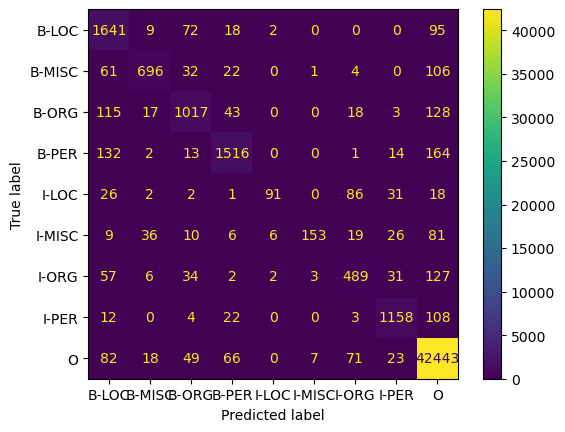

In [30]:
retrieve_metrics_and_cm(dev_file, pred_file, './NB_metrics.txt', './NB_cm.png')

Metrics report saved to ./SVM_metrics.txt
Confusion matrix image saved to ./SVM_cm.png


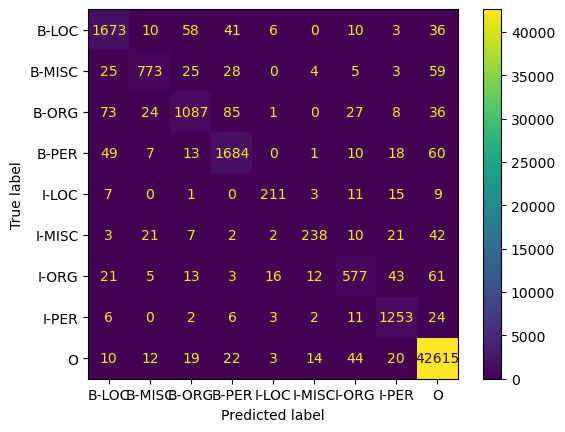

In [31]:
retrieve_metrics_and_cm(dev_file, pred_file_svm,'./SVM_metrics.txt', './SVM_cm.png')

In [32]:
retrieve_weighted_metrics(dev_file, pred_file,'./NB_weighted_metrics.txt')

Metrics report saved to ./NB_weighted_metrics.txt


In [33]:
retrieve_weighted_metrics(dev_file, pred_file_svm,'./SVM_weighted_metrics.txt')

Metrics report saved to ./SVM_weighted_metrics.txt


In [34]:
dev_gold_list, dev_pred_list_NB = retrieve_tag_lists(dev_file, pred_file)
dev_gold_spans = convert_to_spans(dev_gold_list)
dev_pred_spans_NB = convert_to_spans(dev_pred_list_NB)

In [35]:
dev_gold_list, dev_pred_list_SVM = retrieve_tag_lists(dev_file, pred_file_svm)
dev_gold_spans = convert_to_spans(dev_gold_list)
dev_pred_spans_SVM = convert_to_spans(dev_pred_list_SVM)

In [36]:
evaluate_span_based(dev_gold_spans,dev_pred_spans_NB,'./NB_span_metrics.txt')

Metrics report saved to ./NB_span_metrics.txt


In [37]:
evaluate_span_based(dev_gold_spans,dev_pred_spans_SVM,'./SVM_span_metrics.txt')

Metrics report saved to ./SVM_span_metrics.txt


In [38]:
def extract_embeddings_as_features_and_gold(trainingfile, word_embedding_model):
    """
    Extract both one-hot features and word embeddings for tokens in the training data.
    :param trainingfile: the .conll file of the training data.
    :param word_embedding_model: a pretrained word embedding model.
    :type trainingfile: string
    :type word_embedding_model: string of the model file name for KeyedVectors to load
    :return data: list of dictionaries containing features (with word embeddings replacing the 'token' field)
    :return targets: list of gold labels
    """
    data = []
    targets = []
    
    # Load the pre-trained word embedding model
    model = KeyedVectors.load_word2vec_format(f'./model/{word_embedding_model}', binary=True)
    
    with open(trainingfile, 'r', encoding='utf8') as infile:
        for line in infile:
            components = line.rstrip('\n').split()
            if len(components) > 0:
                token = components[0]
                pos_tag = components[1]
                syntactic_tag = components[2]
                uppercase = components[4]
                prev_uppercase = components[5]
                next_uppercase = components[6]
                prev_token = components[7]
                next_token = components[8]
                prefix = components[9]
                suffix = components[10]
                
                # Try to get the word embedding for the token
                if token in model:
                    token_embedding = model[token].tolist()  # Convert numpy array to list for compatibility
                else:
                    token_embedding = [0] * model.vector_size  # Use a zero vector if token is not in the embedding model


                # Try to get the word embedding for the prev_token
                if prev_token in model:
                    prev_token_embedding = model[prev_token].tolist()  # Convert numpy array to list for compatibility
                else:
                    prev_token_embedding = [0] * model.vector_size  # Use a zero vector if token is not in the embedding model


                # Try to get the word embedding for the prev_token
                if next_token in model:
                    next_token_embedding = model[next_token].tolist()  # Convert numpy array to list for compatibility
                else:
                    next_token_embedding = [0] * model.vector_size  # Use a zero vector if token is not in the embedding model
                    
                
                # Create the feature dictionary with token embedding replacing the 'token' field
                feature_dict = {
                    'token_embedding': token_embedding,  # Replace 'token' with 'token_embedding'
                    'prev_token_embedding': prev_token_embedding, # Replace 'prev_token' with 'prev_token_embedding'
                    'next_token_embedding': next_token_embedding, # Replace 'next_token' with 'next_token_embedding'
                    'pos_tag': pos_tag,
                    'syntactic_tag': syntactic_tag,
                    'uppercase': uppercase,
                    'prev_uppercase': prev_uppercase,
                    'next_uppercase': next_uppercase,
                    'prefix': prefix,
                    'suffix': suffix
                }
                data.append(feature_dict)
                targets.append(components[3])  # Gold label in the 3rd column


    return data, targets

In [39]:
train_features_w2v, train_golds = extract_embeddings_as_features_and_gold(new_training_file, 'GoogleNews-vectors-negative300.bin')

In [40]:
print(train_features_w2v[0], train_golds[0])

{'token_embedding': [0.037353515625, -0.203125, 0.212890625, 0.244140625, -0.28515625, -0.034423828125, 0.06689453125, -0.1875, -0.0390625, 0.00848388671875, -0.2890625, -0.08349609375, 0.0908203125, -0.2734375, -0.392578125, -0.1064453125, -0.06591796875, -0.00994873046875, -0.05419921875, -0.041748046875, 0.263671875, 0.07958984375, 0.150390625, 0.1943359375, 0.212890625, 0.0986328125, -0.3359375, 0.158203125, 0.283203125, 0.2333984375, -0.119140625, -0.23046875, 0.26171875, 0.0595703125, 0.026123046875, -0.341796875, -0.154296875, 0.1376953125, 0.0986328125, 0.0556640625, 0.314453125, 0.09814453125, 0.158203125, 0.197265625, 0.022705078125, -0.076171875, -0.296875, 0.21875, -0.359375, 0.1884765625, -0.1083984375, 0.0031585693359375, -0.058349609375, 0.1962890625, 0.12890625, -0.2314453125, -0.392578125, 0.01361083984375, -0.294921875, -0.07763671875, -0.185546875, -0.298828125, 0.01409912109375, 0.021728515625, 0.1298828125, -0.1806640625, -0.015625, 0.1181640625, -0.267578125, -0.1

In [41]:
def prepare_combined_features(dict_features):
    """
    Convert feature dictionaries and targets into SVM-compatible matrices.
    :param dict_features: List of feature dictionaries
    :return: feature_matrix (NumPy array), dict_vectorizer (one-hot encoding)
    """
    # Extract embeddings for token, prev_token, and next_token
    embeddings = np.array([
        np.concatenate([
            sample.pop('token_embedding'),
            sample.pop('prev_token_embedding'),
            sample.pop('next_token_embedding')
        ])
        for sample in dict_features
    ])  # Combine token, prev_token, and next_token embeddings for each sample
    dict_vectorizer = DictVectorizer()  # To handle one-hot features
    one_hot_features = dict_vectorizer.fit_transform(dict_features)  # Convert remaining dictionary entries to one-hot vectors
    
    # Combine embeddings and one-hot features
    feature_matrix = hstack([embeddings, one_hot_features])  # Horizontally stack embedding and one-hot, using the hstack from scipy to avoid error
    
    
    return feature_matrix, dict_vectorizer

In [42]:
def prepare_combined_features_for_input(dict_features, dict_vectorizer):
    """
    Convert new data dictionaries into feature matrices using a pre-trained DictVectorizer.
    :param dict_features: List of feature dictionaries
    :param dict_vectorizer: DictVectorizer from training
    :return: feature_matrix
    """
    # Extract embeddings for token, prev_token, and next_token
    embeddings = np.array([
        np.concatenate([
            sample.pop('token_embedding'),
            sample.pop('prev_token_embedding'),
            sample.pop('next_token_embedding')
        ])
        for sample in dict_features
    ])  # Combine token, prev_token, and next_token embeddings for each sample
    one_hot_features = dict_vectorizer.transform(dict_features)  # Use the DictVectorizer from training
    feature_matrix = hstack([embeddings, one_hot_features])  # Combine embeddings and one-hot features using scipy hstack to avoid error
    return feature_matrix

In [43]:
def create_classifier_with_w2v(train_features, train_targets, modelname):
    if modelname ==  'logreg':
        # TIP: you may need to solve this: https://stackoverflow.com/questions/61814494/what-is-this-warning-convergencewarning-lbfgs-failed-to-converge-status-1
        model = LogisticRegression()
    elif modelname == 'NB':
        model = MultinomialNB()
    elif modelname == 'SVM':
        model = LinearSVC(max_iter=5000)

    feature_matrix_with_w2v, vec_with_w2v = prepare_combined_features(train_features)
    model.fit(feature_matrix_with_w2v, train_targets)
    
    return model, vec_with_w2v

In [44]:
def create_FTSVM_with_w2v(train_features, train_targets):
    model = LinearSVC(C=0.1, max_iter=5000)
    feature_matrix_with_w2v, vec_with_w2v = prepare_combined_features(train_features)
    model.fit(feature_matrix_with_w2v, train_targets)

    return model, vec_with_w2v

In [45]:
w2v_svm_classifier, w2v_svm_vec = create_classifier_with_w2v(train_features_w2v, train_golds, 'SVM')

F:\anaconda\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


In [46]:
type(w2v_svm_classifier)

sklearn.svm._classes.LinearSVC

In [48]:
train_features_w2v, train_golds = extract_embeddings_as_features_and_gold(new_training_file, 'GoogleNews-vectors-negative300.bin')

In [50]:
w2v_svm_classifier_FT, w2v_svm_vec_FT = create_FTSVM_with_w2v(train_features_w2v, train_golds)

F:\anaconda\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


In [52]:
def classify_data_w2v(embedding, classifier, vec, inputdata, outputfile):
    features, _ = extract_embeddings_as_features_and_gold(inputdata, embedding)
    combined_features = prepare_combined_features_for_input(features, vec)
    predictions = classifier.predict(combined_features)
    outfile = open(outputfile, 'w')
    counter = 0
    for line in open(inputdata, 'r'):
        if len(line.rstrip('\n').split()) > 0:
            outfile.write(line.rstrip('\n') + '\t' + predictions[counter] + '\n')
            counter += 1
    outfile.close()

In [54]:
w2v_dev_pred_file = './w2v_svm_pred.conll'

In [56]:
w2v_dev_pred_file_FT = './w2v_svm_pred_FT.conll'

In [58]:
classify_data_w2v('GoogleNews-vectors-negative300.bin', w2v_svm_classifier, w2v_svm_vec, new_dev_file, w2v_dev_pred_file)

In [60]:
classify_data_w2v('GoogleNews-vectors-negative300.bin', w2v_svm_classifier_FT, w2v_svm_vec_FT, new_dev_file, w2v_dev_pred_file_FT)

Metrics report saved to ./svm_w2v_metrics.txt
Confusion matrix image saved to ./svm_w2v_cm.png


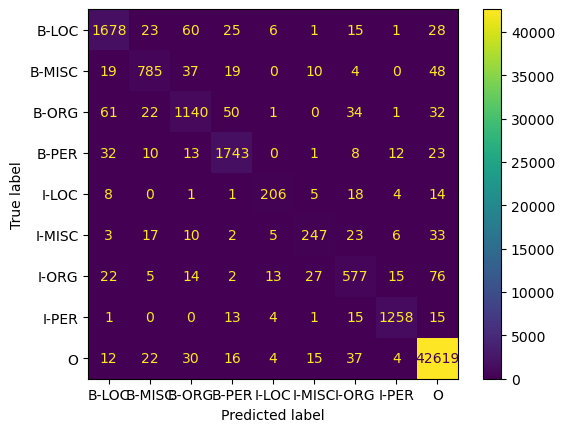

In [62]:
retrieve_metrics_and_cm(dev_file, w2v_dev_pred_file, './svm_w2v_metrics.txt', './svm_w2v_cm.png')

Metrics report saved to ./svm_w2v_metrics_FT.txt
Confusion matrix image saved to ./svm_w2v_cm_FT.png


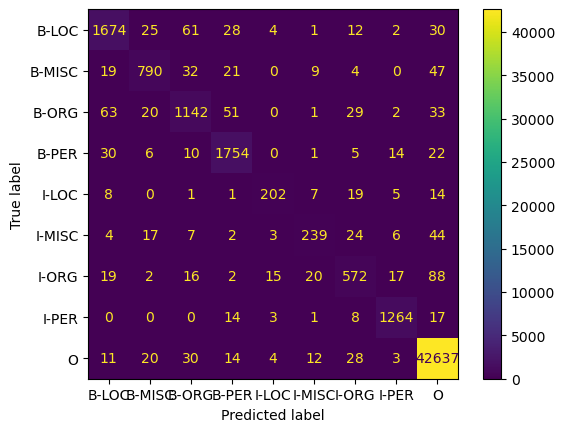

In [64]:
retrieve_metrics_and_cm(dev_file, w2v_dev_pred_file_FT, './svm_w2v_metrics_FT.txt', './svm_w2v_cm_FT.png')

In [66]:
retrieve_weighted_metrics(dev_file, w2v_dev_pred_file, './svm_w2v_weighted_metrics.txt')

Metrics report saved to ./svm_w2v_weighted_metrics.txt


In [68]:
retrieve_weighted_metrics(dev_file, w2v_dev_pred_file_FT, './svm_w2v_weighted_metrics_FT.txt')

Metrics report saved to ./svm_w2v_weighted_metrics_FT.txt


In [70]:
def span_based_eva_pipeline(gold_file, pred_file,output_txt):
    gold_list, pred_list = retrieve_tag_lists(gold_file, pred_file)
    gold_spans = convert_to_spans(gold_list)
    pred_spans = convert_to_spans(pred_list)
    evaluate_span_based(gold_spans,pred_spans,output_txt)

In [72]:
span_based_eva_pipeline(dev_file,w2v_dev_pred_file, './svm_w2v_span_metrics.txt')

Metrics report saved to ./svm_w2v_span_metrics.txt


In [74]:
span_based_eva_pipeline(dev_file,w2v_dev_pred_file_FT, './svm_w2v_span_metrics_FT.txt')

Metrics report saved to ./svm_w2v_span_metrics_FT.txt


In [47]:
w2v_svm_classifier.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': 'warn',
 'fit_intercept': True,
 'intercept_scaling': 1,
 'loss': 'squared_hinge',
 'max_iter': 5000,
 'multi_class': 'ovr',
 'penalty': 'l2',
 'random_state': None,
 'tol': 0.0001,
 'verbose': 0}

In [48]:
model_SVM.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': 'warn',
 'fit_intercept': True,
 'intercept_scaling': 1,
 'loss': 'squared_hinge',
 'max_iter': 1000,
 'multi_class': 'ovr',
 'penalty': 'l2',
 'random_state': None,
 'tol': 0.0001,
 'verbose': 0}

In [49]:
from sklearn.model_selection import GridSearchCV

In [102]:
feature_matrix, _ = prepare_combined_features(train_features_w2v)

In [106]:
# Gridsearch
param_grid = {
    'C': [0.1, 1],  # Regularization parameter range
    'max_iter': [5000, 10000],  # max_iteration range
}


linear_svc = LinearSVC()

# GridSearchCV
grid_search = GridSearchCV(
    estimator=linear_svc,
    param_grid=param_grid,
    scoring='f1_macro',  # using F1_macro as the standard
    cv=3,  # 3-fold validation
    verbose=2,
    n_jobs=-1  # Using all CPU cores
)


grid_search.fit(feature_matrix, train_golds)

# printing best parameters and the corresponding macro F1 score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

best_model = grid_search.best_estimator_

Fitting 3 folds for each of 4 candidates, totalling 12 fits


F:\anaconda\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Best Parameters: {'C': 0.1, 'max_iter': 5000}
Best Cross-Validation Score: 0.8578939794316268
